# Used Car Prices


## Libraries and functions

In [2]:
# Libraries
import pandas as pd
import numpy  as np
import math
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# reading the dataframe
df = pd.read_csv('train.csv')
df2 = pd.read_csv('used_cars.csv')

c:\Users\yurir\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
c:\Users\yurir\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# functions

def tipificacao(df : pd.core.frame.DataFrame):
    '''
    Retrabalha variáveis categóricas e numéricas da maneira
    adequada para esse caso

    Attributes:
        df: pandas.core.frame.DataFrame
    '''
    # using year as a categorical column
    df['model_year'] = df['model_year'].astype(str)

    # deleting $ and , from price
    try:
        df[['milage', 'price']] = df[['milage', 
                                      'price']].map(lambda x: int(''.join(re.findall(r'\d+', x))))
    
        df['accident'] = df.accident.str.extract('(\d+)') 
    except:
        pass

    return df

def fuel_type_transform(df : pd.core.frame.DataFrame):
    '''
    Substitui os valores faltantes relacionados a coluna 'fuel_type' pelo
    valor mais frequente considerando o modelo do carro, marca e ano

    Attributes:
        df: pandas.core.frame.DataFrame
    '''

    # Substituindo '–' como opção 
    df['fuel_type'] = df['fuel_type'].replace('–', np.nan)

    # Suponha que a variável categórica dependa de outra variável categórica 'outra_coluna'
    df['fuel_type'] = df.groupby('model')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df['fuel_type'] = df.groupby('brand')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
    df['fuel_type'] = df.groupby('model_year')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'default'))

    return df

def categoriza_marcas_luxo(df : pd.core.frame.DataFrame,
                           list_of_luxury_brands : list = ['Mercedes-Benz',
                                                           'Porsche', 'Land', 
                                                            'Lexus', 'Jaguar', 
                                                            'Bentley', 'Maserati', 
                                                            'Lamborghini','Rolls-Royce', 
                                                            'Ferrari', 'McLaren', 
                                                            'Aston', 'Maybach']) :
    
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in list_of_luxury_brands else 0)

    return df

def extracao_dados_motor(df: pd.core.frame.DataFrame):
    def extract_horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None

    def extract_engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None
        
    def extract_cylinder_number(text):
    # Procura por "Cylinder" seguido de um número
        match = re.search(r'(\d+)\s*Cylinder', text)
    
        if match:
            return int(match.group(1))  # Retorna o número encontrado
        return None  # Retorna None se não encontrar a palavra "Cylinder"

    df['cilinders'] = df['engine'].apply(extract_cylinder_number)
    df['Horsepower'] = df['engine'].apply(extract_horsepower)
    df['Engine_Size'] = df['engine'].apply(extract_engine_size)
    df['Power_to_Weight_Ratio'] = round(df['Horsepower'] / df['Engine_Size'], 2)

    return df

def extracao_dados_transmission(df: pd.core.frame.DataFrame):

    def classify_transmission(transmission):
        transmission = transmission.lower()  # Convertendo tudo para minúsculas
        if any(x in transmission for x in ['a/t', 'automatic', 'dct', 'cvt', 'CVT', 'AT', 'At/Mt', 'Overdrive']):
            return 'A/T'
        elif any(x in transmission for x in ['m/t', 'manual', 'pdk']):
            return 'manual'
        elif 'dual' in transmission:
            return 'Dual'
        else:
            return 'other'
        
    def get_speed_transmission(transmission):
    # Procura por "Speed" seguido de um número
        match = re.search(r'(\d+)-Speed', transmission)
    
        # Se encontrar um match, retornar o número, caso contrário, retornar None
        return int(match.group(1)) if match else None
    
    df['transmission2'] = df['transmission'].apply(classify_transmission)
    df['speed_transmission'] = df['transmission'].apply(get_speed_transmission)
    return df

def categoriza_decadas(ano):
    decada = (ano // 10) * 10
    parte = 1 if ano % 10 < 5 else 2
    return f"{decada}.{parte}"

def mostra_nulos(df : pd.core.frame.DataFrame):
    '''
    Retorna uma tabela com o nome das colunas que possui valores nulos e 
    a quantidade total desses valores

    Attributes:
        df: pandas.core.frame.DataFrame
    
    '''
    
    # Contar os valores nulos em cada coluna
    null_counts = df.isnull().sum()

    # Filtrar colunas que possuem valores nulos
    cols_with_nulls = null_counts[null_counts > 0]

    result_df = cols_with_nulls.reset_index()
    result_df.columns = ['Colunas', 'Qntde nulos']
    return result_df

def trata_nulos(df : pd.core.frame.DataFrame):
    '''
    Trata coluna por coluna o que fazer com os valores nulos

    Attributes:
        df: pandas.core.frame.DataFrame
    '''

    # Engine col
    # Após extensiva análise, conclui-se que todos os valores faltantes correspondem
    # à carros que possuim motor elétrico
    df['fuel_type'] = df['fuel_type'].fillna('Eletric')

    # accident col
    # Não existe variação no numero de acidentes, logo para qualquer valor declarado
    # que não seja um, corresponde-se a zero
    df['accident'] = df['accident'].fillna('None reported')

    # clean_title
    df['clean_title'] = df['clean_title'].fillna('No')


    #insere a média do modelo nos valores faltantes de horsepower
    mean_hp_by_model = df.groupby('model')['Horsepower'].transform('mean')
    df['Horsepower'] = round(df['Horsepower'].fillna(mean_hp_by_model), 2)

    #insere a média da marca nos valores faltantes de horsepower
    mean_hp_by_brand = df.groupby('brand')['Horsepower'].transform('mean')
    df['Horsepower'] = round(df['Horsepower'].fillna(mean_hp_by_brand), 2)

    # Caso não exista uma média de horsepower de marca, inserir a geral
    global_mean_hp = df['Horsepower'].mean()
    df['Horsepower'] = round(df['Horsepower'].fillna(global_mean_hp), 2)

    #insere a média da modelo nos valores faltantes de horsepower
    mode_cl_by_model = df.groupby('model')['cilinders'].transform('mean')
    df['cilinders'] = round(df['cilinders'].fillna(mode_cl_by_model), 0)

    #insere a média da marca nos valores faltantes de cilindradas
    mode_cl_by_brand = df.groupby('brand')['cilinders'].transform('mean')
    df['cilinders'] = round(df['cilinders'].fillna(mode_cl_by_brand), 0)

    # Caso não exista uma média de horsepower de marca, inserir a geral
    global_mode_cl = df['cilinders'].mean()
    df['cilinders'] = round(df['cilinders'].fillna(global_mode_cl), 0)
    
    return df

def tratamento_dos_dados(df : pd.core.frame.DataFrame):

    tipificacao(df)
    extracao_dados_motor(df)
    categoriza_marcas_luxo(df)
    df['decada'] = df['model_year'].astype('int').apply(categoriza_decadas)
    df['decada'] = df['decada'].astype('str')
    trata_nulos(df)
    try :
        df.drop(df[df.price >  500000].index, inplace=True)
    except:
        pass
    fuel_type_transform(df)
    extracao_dados_transmission(df)
    
    return df

### Visualizando o dataframe inicial

In [4]:
df.head(15)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


## Tratamento dos dados

### Recategorização

Algumas variáveis numéricas estão classificadas como "string" como milage, e outras que deveriam ser consideradas como categóricas (model_year) estão como numéricas

In [5]:
df = tipificacao(df)

Adicionando variáveis advindas de especificações de motor

In [6]:
df = extracao_dados_motor(df)

Adicionando tipificação da categoria da marca (luxo ou não)

In [7]:
df = categoriza_marcas_luxo(df)

recategorizando a coluna year para menos categorias, por década

In [8]:
df['decada'] = df['model_year'].astype('int').apply(categoriza_decadas)
df['decada'] = df['decada'].astype('str')

In [9]:
df['decada']

0         2000.2
1         2000.1
2         2000.1
3         2010.2
4         2020.1
           ...  
188528    2010.2
188529    2010.2
188530    2020.1
188531    2020.1
188532    2010.2
Name: decada, Length: 188533, dtype: object

### Dados nulos

In [10]:
mostra_nulos(df)

,Colunas,Qntde nulos
0,fuel_type,5083
1,accident,2452
2,clean_title,21419
3,cilinders,37855
4,Horsepower,33259
5,Engine_Size,37728
6,Power_to_Weight_Ratio,37886


In [11]:
df = trata_nulos(df)

In [12]:
mostra_nulos(df)

,Colunas,Qntde nulos
0,Engine_Size,37728
1,Power_to_Weight_Ratio,37886


### Tratando ouliers

Por trimming

In [13]:
df.drop(df[df.price >  500000].index, inplace=True)
df.drop(df[df.milage >  350000].index, inplace=True)
df.drop(df[df.Horsepower >  800].index, inplace=True)
df.drop(df[df.cilinders <  0].index, inplace=True)
df.drop(df[df['model_year'].astype(int) <  1992].index, inplace=True)

Por Winsorização

### Tratamentos adicionais

(casos especiais e ajustes fino)

In [14]:
df = fuel_type_transform(df)

C:\Users\yurir\AppData\Local\Temp\ipykernel_2432\1165869946.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fuel_type'] = df.groupby('model')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


In [15]:
# Aplicar a função para criar a nova coluna transmission
extracao_dados_transmission(df)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,clean_title,price,cilinders,Horsepower,Engine_Size,Power_to_Weight_Ratio,Is_Luxury_Brand,decada,transmission2,speed_transmission
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,Yes,4200,4.0,172.00,1.6,107.50,0,2000.2,A/T,NaN
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,Yes,4999,8.0,252.00,3.9,64.62,0,2000.1,A/T,NaN
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,Yes,13900,8.0,320.00,5.3,60.38,0,2000.1,A/T,NaN
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,Yes,45000,8.0,420.00,5.0,84.00,0,2010.2,Dual,NaN
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,Yes,97500,4.0,208.00,2.0,104.00,1,2020.1,A/T,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,...,Yes,27500,8.0,420.00,6.2,67.74,0,2010.2,Dual,NaN
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,...,Yes,30000,6.0,385.00,3.0,128.33,1,2010.2,A/T,8.0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,Yes,86900,8.0,469.00,4.0,117.25,1,2020.1,A/T,7.0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,...,No,84900,6.0,341.11,NaN,NaN,0,2020.1,A/T,1.0


### Data types

assegurando o funcionamento dos modelos e encoders

In [16]:
df = df.apply(lambda col: col.astype('string') if col.dtype == 'object' else col)


In [17]:
print(df.dtypes)

id                                int64
brand                    string[python]
model                    string[python]
model_year               string[python]
milage                            int64
fuel_type                string[python]
engine                   string[python]
transmission             string[python]
ext_col                  string[python]
int_col                  string[python]
accident                 string[python]
clean_title              string[python]
price                             int64
cilinders                       float64
Horsepower                      float64
Engine_Size                     float64
Power_to_Weight_Ratio           float64
Is_Luxury_Brand                   int64
decada                   string[python]
transmission2            string[python]
speed_transmission              float64
dtype: object


## Incluindo (ou não) dados do dataset original

In [18]:
#tratamento_dos_dados(df2)
#df = pd.concat([df, df2], ignore_index=True)
#df.drop(columns=['id'], inplace=True)

## Data Analysis

### Numeric data Analysis

In [19]:
df.describe().applymap(lambda x: f"{x:0.0f}")

C:\Users\yurir\AppData\Local\Temp\ipykernel_2432\2591208043.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x: f"{x:0.0f}")


,id,milage,price,cilinders,Horsepower,Engine_Size,Power_to_Weight_Ratio,Is_Luxury_Brand,speed_transmission
count,187528,187528,187528,187528,187528,150545,150387,187528,103489
mean,94261,65907,41413,6,343,4,93,0,7
std,54424,49619,44472,2,110,1,27,0,2
min,0,100,2000,3,70,1,28,0,1
25%,47129,24500,17000,6,265,3,70,0,6
50%,94270,57932,30500,6,329,4,87,0,7
75%,141386,95500,49500,8,412,5,113,1,8
max,188532,333361,491836,12,797,8,262,1,10


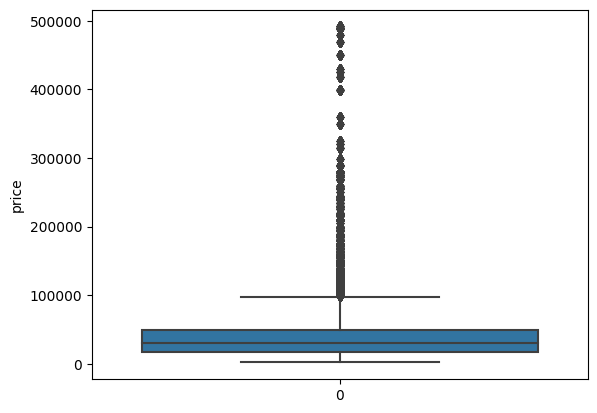

In [20]:
sns.boxplot(y='price', data=df)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.xticks(rotation=0)  # Ajusta a rotação dos ticks, se necessário
# Exibir o gráfico
plt.show()

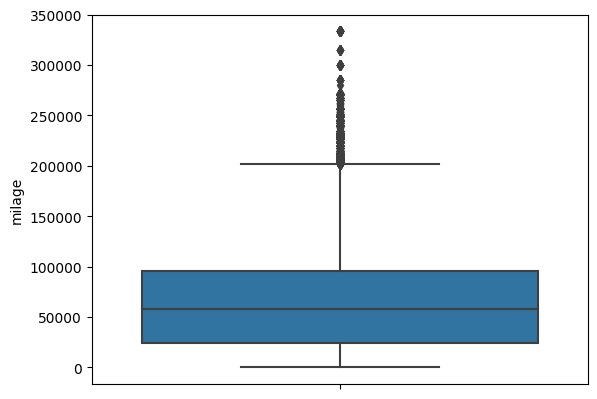

In [21]:
sns.boxplot(y='milage', data=df)
# Exibir o gráfico
plt.show()

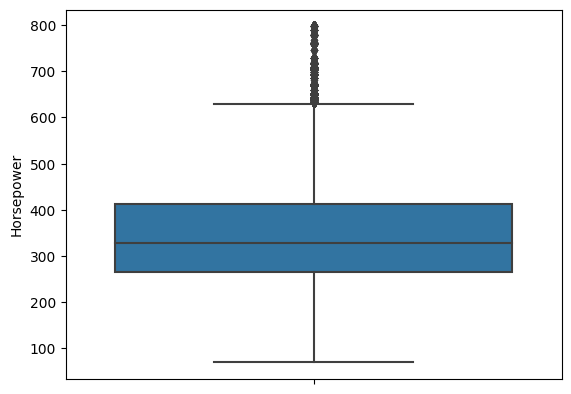

In [22]:
sns.boxplot(y='Horsepower', data=df)
# Exibir o gráfico
plt.show()

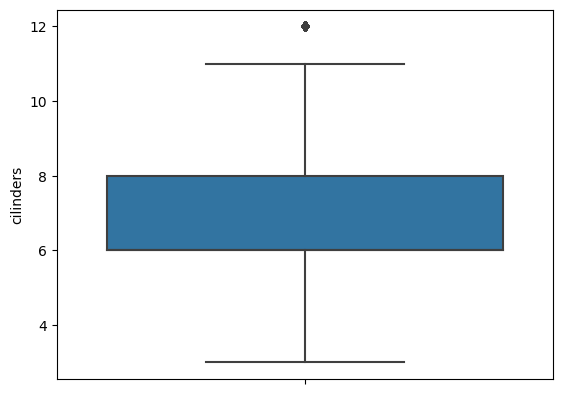

In [23]:
sns.boxplot(y='cilinders', data=df)
# Exibir o gráfico
plt.show()

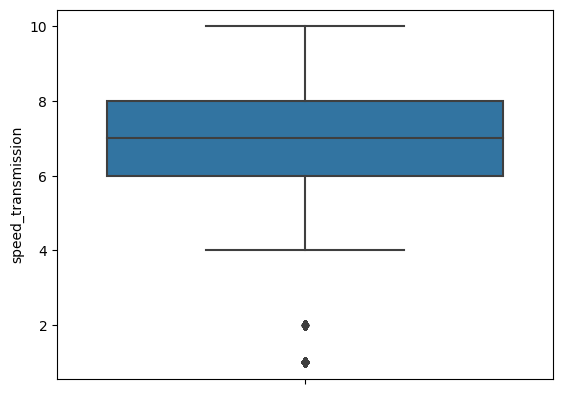

In [24]:
sns.boxplot(y='speed_transmission', data=df)
# Exibir o gráfico
plt.show()

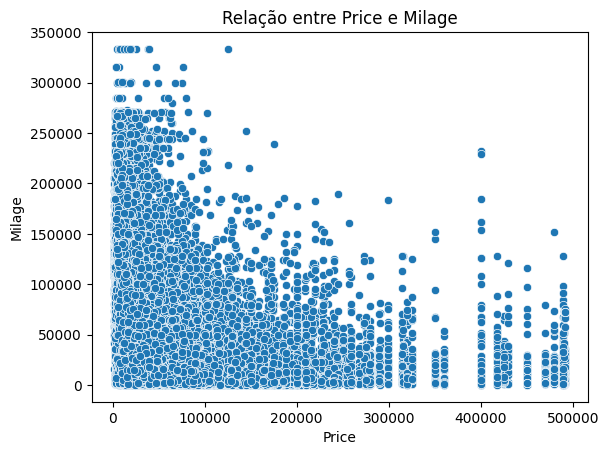

In [25]:
# Supondo que você tenha um DataFrame chamado 'df' com as colunas 'variavel_x' e 'variavel_y'
sns.scatterplot(x='price', y='milage', data=df)

# Adicionar título e rótulos aos eixos, se necessário
plt.title('Relação entre Price e Milage')
plt.xlabel('Price')
plt.ylabel('Milage')

# Exibir o gráfico
plt.show()


relação inversa forte

Aparenta 

$$y = a * \frac{1}{x}$$

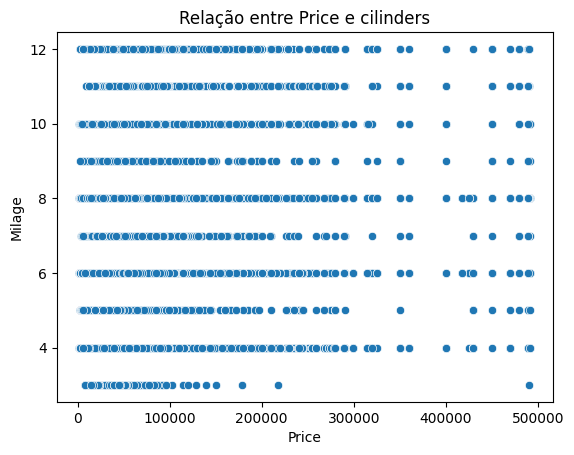

In [26]:
# Supondo que você tenha um DataFrame chamado 'df' com as colunas 'variavel_x' e 'variavel_y'
sns.scatterplot(x='price', y='cilinders', data=df)

# Adicionar título e rótulos aos eixos, se necessário
plt.title('Relação entre Price e cilinders')
plt.xlabel('Price')
plt.ylabel('Milage')

# Exibir o gráfico
plt.show()


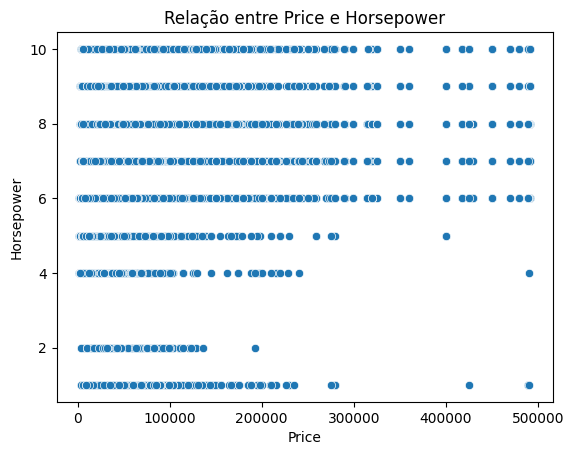

In [27]:
# Supondo que você tenha um DataFrame chamado 'df' com as colunas 'variavel_x' e 'variavel_y'
sns.scatterplot(x='price', y='speed_transmission', data=df)

# Adicionar título e rótulos aos eixos, se necessário
plt.title('Relação entre Price e Horsepower')
plt.xlabel('Price')
plt.ylabel('Horsepower')

# Exibir o gráfico
plt.show()

Não parece haver relação entre preço e Power_to_Weight_Ratio

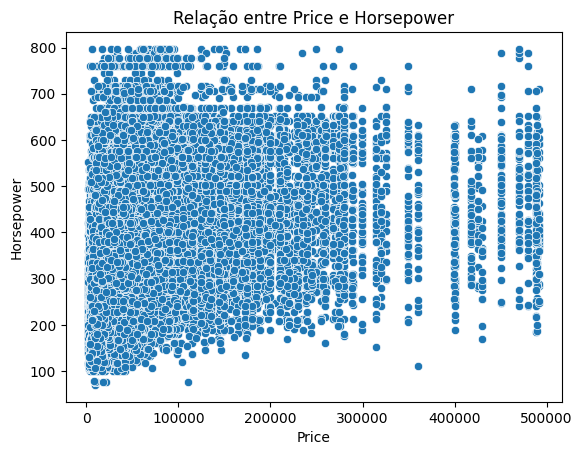

In [28]:
# Supondo que você tenha um DataFrame chamado 'df' com as colunas 'variavel_x' e 'variavel_y'
sns.scatterplot(x='price', y='Horsepower', data=df)

# Adicionar título e rótulos aos eixos, se necessário
plt.title('Relação entre Price e Horsepower')
plt.xlabel('Price')
plt.ylabel('Horsepower')

# Exibir o gráfico
plt.show()


### Variáveis Categóricas

In [29]:
# filtrando apenas os valores string em df p/ variáveis categóricas com poucas categorias
catdf = df[['brand','decada', 'fuel_type', 'transmission2',
            'accident' , 'clean_title', 'Is_Luxury_Brand']]

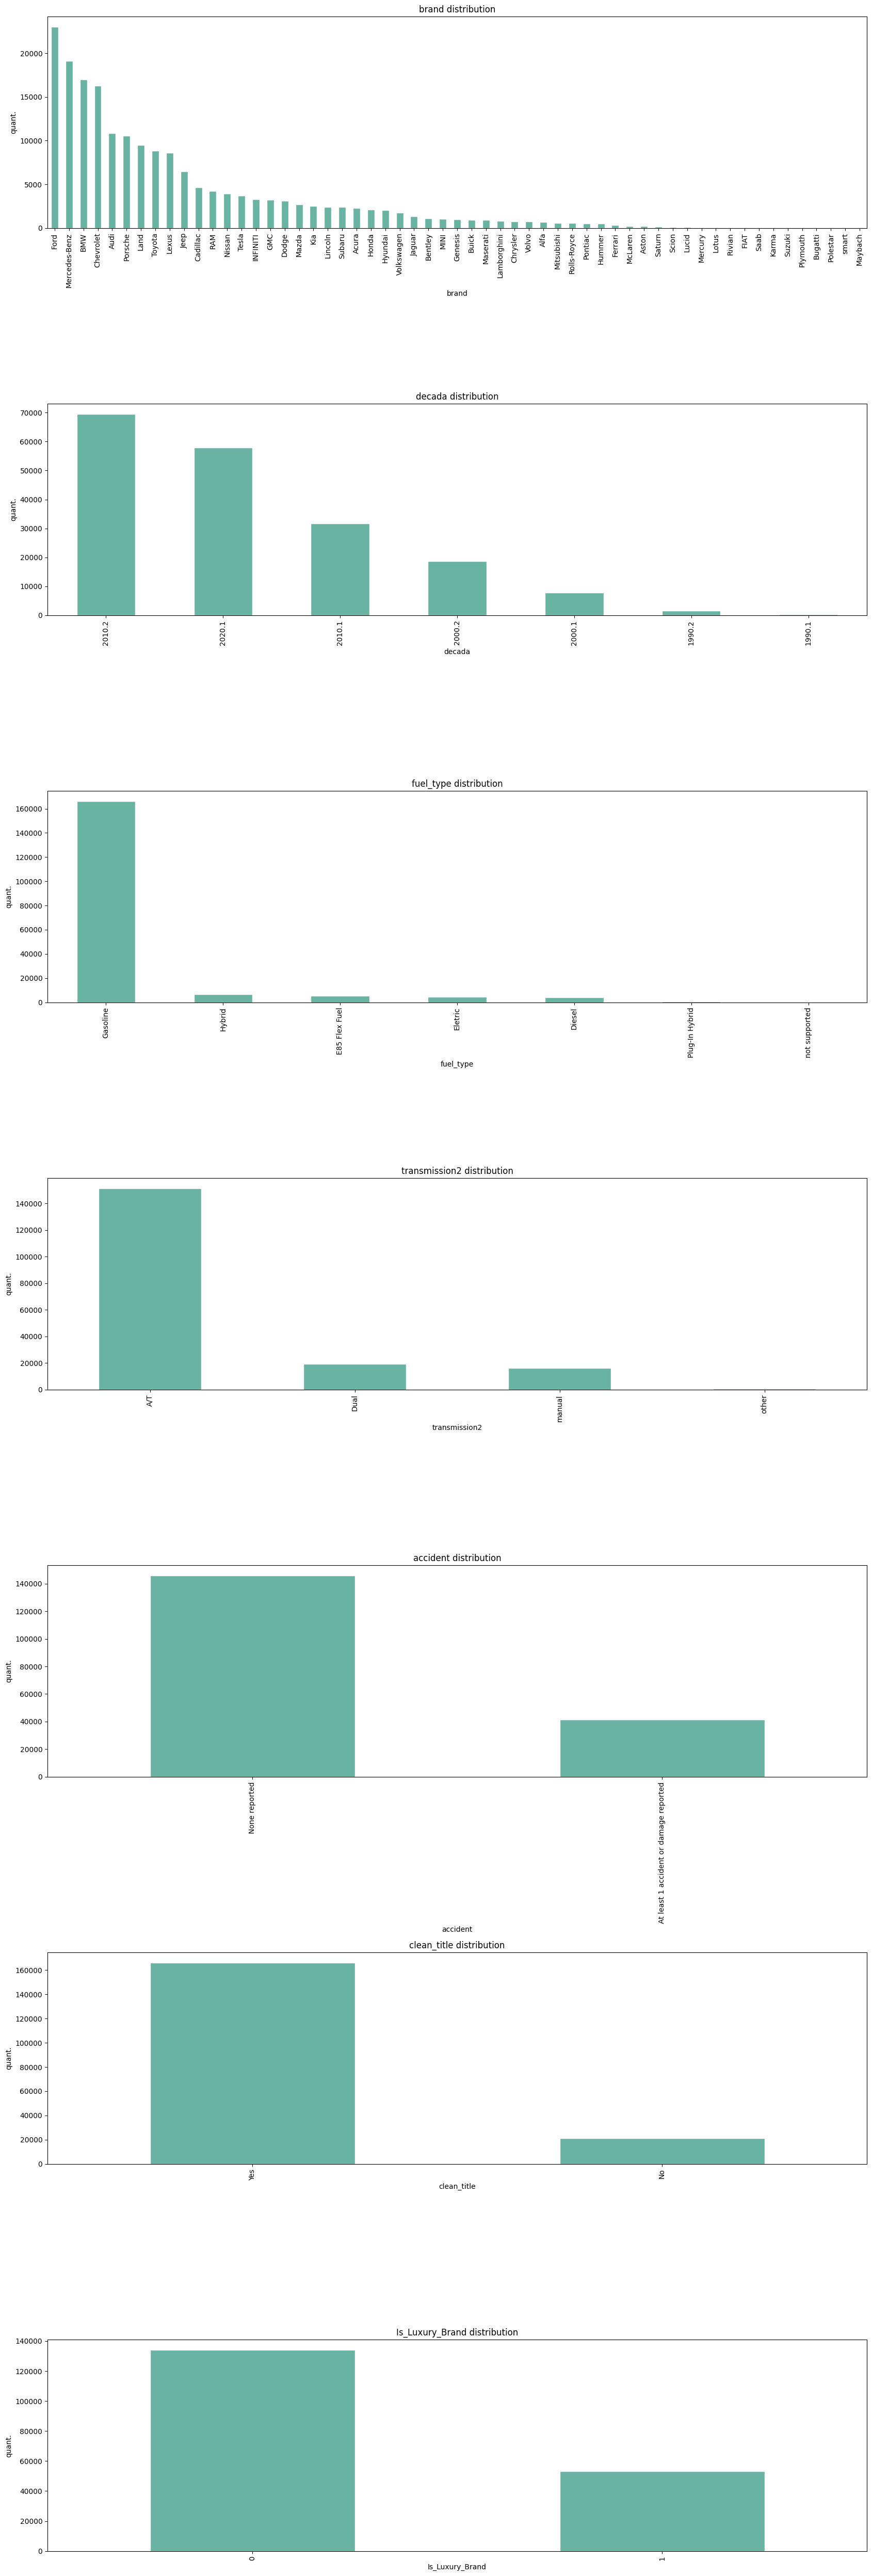

In [30]:
# Initialize a 2x5 charts
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(17, 50))

# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(catdf.columns):
    
    # Add the histogram
    catdf[column].value_counts().plot(ax=axes[i], # Define on which ax we're working on
                      edgecolor='white', # Color of the border
                      color='#69b3a2',  # Color of the bins
                      kind='bar'
                    )
    
    # Add title and axis label
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('quant.') 

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

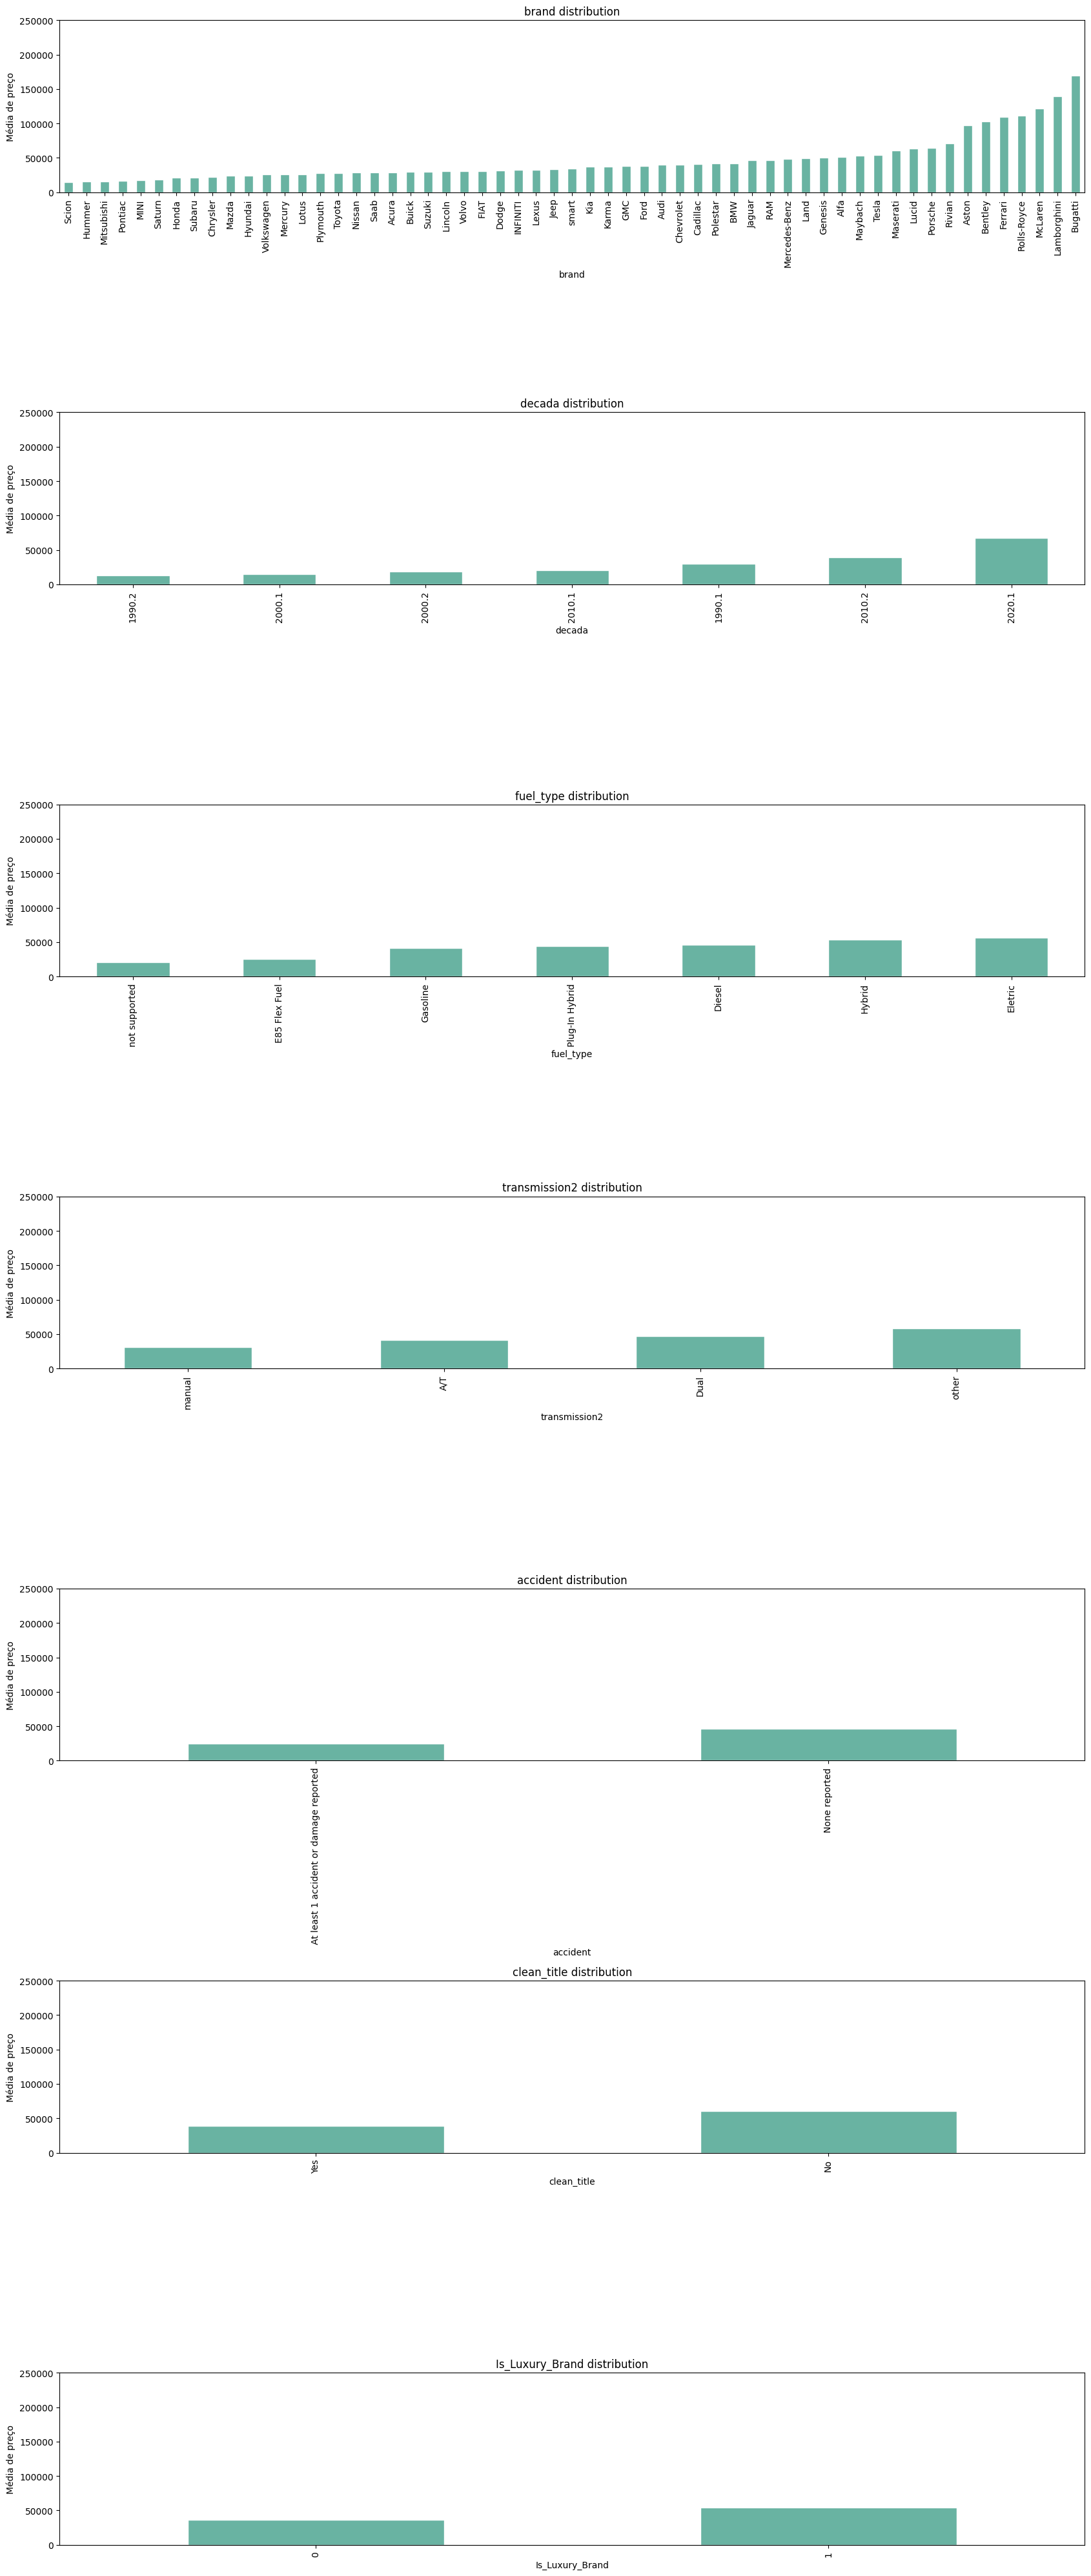

In [31]:
# Initialize a 2x22 charts
fig, axes = plt.subplots(nrows=7, 
                         ncols=1, 
                         figsize=(17, 40))

# Flatten the axes array (m
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(catdf.columns):
    
    # Add the histogram
    df.groupby([column]).mean(numeric_only= True)['price'].sort_values().plot(ax=axes[i], # Define on which ax we're working on
                      edgecolor='white', # Color of the border
                      color='#69b3a2',  # Color of the bins
                      kind='bar'
                    )
    
    # Add title and axis label
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Média de preço') 
    axes[i].set_ylim(0, 250000)
    
plt.tight_layout()
plt.show()

### Variável resposta e testes estatísticos

In [39]:
df['Is_Luxury_Brand']

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,clean_title,price,cilinders,Horsepower,Engine_Size,Power_to_Weight_Ratio,Is_Luxury_Brand,decada,transmission2,speed_transmission
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,Yes,4200,4.0,172.00,1.6,107.50,0,2000.2,A/T,NaN
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,Yes,4999,8.0,252.00,3.9,64.62,0,2000.1,A/T,NaN
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,Yes,13900,8.0,320.00,5.3,60.38,0,2000.1,A/T,NaN
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,Yes,45000,8.0,420.00,5.0,84.00,0,2010.2,Dual,NaN
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,Yes,97500,4.0,208.00,2.0,104.00,1,2020.1,A/T,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,...,Yes,27500,8.0,420.00,6.2,67.74,0,2010.2,Dual,NaN
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,...,Yes,30000,6.0,385.00,3.0,128.33,1,2010.2,A/T,8.0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,Yes,86900,8.0,469.00,4.0,117.25,1,2020.1,A/T,7.0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,...,No,84900,6.0,341.11,NaN,NaN,0,2020.1,A/T,1.0


## Modeling


In [43]:
# Separar os dados em dois grupos
df_luxury = df[df['Is_Luxury_Brand'] == 1]
df_non_luxury = df[df['Is_Luxury_Brand'] == 0]

numerical_features = ['milage', 'Horsepower', 'cilinders', 'speed_transmission']
categorical_features = ['clean_title', 'accident', 'transmission', 'fuel_type', 'decada', 'brand']
target = 'price'

X_luxury = df_luxury[numerical_features + categorical_features]
y_luxury = df_luxury[target]

X_non_luxury = df_non_luxury[numerical_features + categorical_features]
y_non_luxury = df_non_luxury[target]

# Ajustar o OneHotEncoder para todo o conjunto de dados (luxury e non-luxury)
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),   # Escalar variáveis numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)   # Codificar variáveis categóricas
    ]
)

# Ajustar o preprocessor em todos os dados para garantir consistência
preprocessor.fit(df[numerical_features + categorical_features])

# Pipeline final com o pré-processamento e o modelo LGBM para os dois grupos
model_pipeline_luxury = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor())
])

model_pipeline_non_luxury = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor())
])

# Treinar os modelos
model_pipeline_luxury.fit(X_luxury, y_luxury)
model_pipeline_non_luxury.fit(X_non_luxury, y_non_luxury)

# Fazer previsões
df_luxury['prediction'] = model_pipeline_luxury.predict(X_luxury)
df_non_luxury['prediction'] = model_pipeline_non_luxury.predict(X_non_luxury)

# Unir as previsões com base no ID, preservando a ordem original
df_predictions = pd.concat([df_luxury[['id', 'prediction']], df_non_luxury[['id', 'prediction']]])
df_predictions = df_predictions.set_index('id').reindex(df['id']).reset_index()

# Resultado
print(df_predictions)

ValueError: Number of features of the model must match the input. Model n_features_ is 85 and input n_features is 118

In [44]:
model_pipeline_luxury

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['milage', 'Horsepower',
                                                   'cilinders',
                                                   'speed_transmission']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['clean_title', 'accident',
                                                   'transmission', 'fuel_type',
                                                   'decada', 'brand'])])),
                ('regressor', LGBMRegressor())])

In [32]:
# Definir as features e o alvo (target)
numerical_features = ['milage', 'Horsepower', 'cilinders', 'speed_transmission']
categorical_features = ['clean_title', 'accident', 'transmission','fuel_type', 'decada', 'Is_Luxury_Brand']
target = 'price'

# Separar as features (X) e o alvo (y)
X = df[numerical_features + categorical_features]
y = df[target]

X_train,X_test,y_train,y_test=train_test_split(
    X,y, 
    train_size = 0.80, 
    random_state = 1)

# Pipeline de pré-processamento: transformar as variáveis categóricas e numéricas
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),   # Escalar variáveis numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)   # Codificar variáveis categóricas
    ]
)

# Pipeline final com o pré-processamento e o modelo GradientBoostingRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(n_estimators = 900,
                                    learning_rate = 0.01,
                                    max_depth = 12,
                                    min_child_samples = 100,
                                    colsample_bytree = 0.5,
                                    subsample = 0.2))
])

# Treinar o modelo
model_pipeline.fit(X, y)

#y_pred = model_pipeline.predict(X_test)
#math.sqrt(mean_squared_error(y_test, y_pred))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['milage', 'Horsepower',
                                                   'cilinders',
                                                   'speed_transmission']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['clean_title', 'accident',
                                                   'transmission', 'fuel_type',
                                                   'decada',
                                                   'Is_Luxury_Brand'])])),
                ('regressor',
                 LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01,
                               max_depth=12, min_child_samples=100,
                               n_estimators=900, subsample=0.2))])

In [33]:
# Acessar o modelo diretamente dentro do pipeline
lgbm_model = model_pipeline.named_steps['regressor']

# Ver as importâncias das features
importances = lgbm_model.feature_importances_

# Listar as colunas do modelo (após o OneHotEncoder, as colunas categóricas foram expandidas)
feature_names = numerical_features + list(model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Criar um DataFrame para organizar as importâncias
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar as features por importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(25)


,Feature,Importance
1,Horsepower,6426
0,milage,5164
2,cilinders,1868
3,speed_transmission,1819
74,Is_Luxury_Brand_0,943
4,clean_title_No,817
73,decada_2020.1,749
72,decada_2010.2,662
40,transmission_8-Speed Automatic,482
5,clean_title_Yes,461


In [34]:
'''# hiperparametrização


# Definir os hiperparâmetros para fazer a busca em grid
param_grid = {
    'regressor__n_estimators': [900, 500, 300],   # Número de árvores
    'regressor__learning_rate': [0.3, .5, .01, .001],  # Taxa de aprendizado
    'regressor__max_depth': [9, 12, 7],   # Profundidade máxima das árvores
    'regressor__min_child_samples': [80, 60, 100],  # Mínimo de amostras por folha
    'regressor__colsample_bytree': [0.3, 0.5, 0.7],  # Fração de features usadas por árvore
    'regressor__subsample': [0.2, 0.1, 0.01, 0.5]  # Fração de amostras usadas em cada árvore
}

# Configurar o GridSearchCV com o pipeline e os hiperparâmetros
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=2,  # Número de folds para validação cruzada
    scoring='neg_mean_squared_error',  # Métrica de avaliação (RMSE)
    verbose=10,  # Nível de informação durante o processo
    n_jobs=-6  # Paralelizar o processo
)
 
# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Exibir os melhores parâmetros
print(f"Melhores hiperparâmetros: {grid_search.best_params_}") '''

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


KeyboardInterrupt: 

## Submit

In [35]:
# Chamando a base de testes
X_test = pd.read_csv('test.csv')
tratamento_dos_dados(X_test)

# Fazer previsões
y_pred = model_pipeline.predict(X_test)

C:\Users\yurir\AppData\Local\Temp\ipykernel_2432\1165869946.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fuel_type'] = df.groupby('model')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


In [36]:
submission = pd.DataFrame({
    'price': y_pred
    },
    index = X_test['id']
    )

submission.to_csv('./submission14.csv')